<div>
<h1>Digital Signals: Quantization</h1> 
</div>

<br/>

<p>
Following Section 2.2.2.2 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>,  we discuss in this notebook a discretization technique called quantization.</a>
</p> 

## Discretization

In the [notebook on sampling](./C2S2_12_DigitalSignalSampling.ipynb), we have seen how this process transforms a continuous time axis (encoded by $\mathbb{R}$) into a discrete time axis (encoded by $\mathbb{Z}$). This is only the first step in an analog-to-digital conversion of a signal. In the second step, one needs to replace the continuous range of possible amplitudes (again encoded by $\mathbb{R}$) by a discrete range of possible values (encoded by a discrete set $\Gamma\subset \mathbb{R}$). This process is commonly known as **quantization**. This two-step discretization process is illustrated by the following figure.

<img src="../data/C2/FMP_C2_F13.png" width="600px" align="middle" alt="C0">

## Uniform Quantization

A quantization can be modeled by a function $Q:\mathbb{R}\to\Gamma$, referred to as the **quantizer**, which assigns to each amplitude value $a\in\mathbb{R}$ a value $Q(a)\in\Gamma$. Many of the quantizers used simply round off or truncate the analog value to some units of precision. For example, a typical **uniform** quantizer with a **quantization step size** equal to some value $\Delta$ spaces the quantization levels uniformly. A formal definition is given by 

\begin{equation}
    Q(a) := \mathrm{sgn}(a) \cdot \Delta \cdot \left\lfloor \frac{|a|}{\Delta} + \frac{1}{2} \right\rfloor   
\end{equation}

for $a\in\mathbb{R}$, were $\mathrm{sgn}(\cdot)$ is the signum function that yields the sign of a real number and the brackets $\lfloor \cdot \rfloor$ truncate a real number to yield the largest integer below this number. Note that, in the case of $\Delta=1$, the quantizer $Q$ is simple rounding to the nearest integer.

## Quantization Error

Like sampling, quantization is generally a lossy operation, because different analog values may be mapped to the same digital value. The difference between the actual analog value and the quantized value is called the **quantization error**. The following figure sketches the graph of the quantization function $Q$ for $a\in\mathbb{R}$ and a quantization step size $\Delta>0$ as well as the absolute quantization error.

<img src="../data/C2/FMP_C2_E09.png" width="300px" align="middle" alt="C0">

Reducing the quantization step size $\Delta$ typically leads to smaller quantization errors. However, at the same time, the number of quantized values (and therefore also the number of bits needed to encode these values) increases. In the example shown at the beginning of this notebook, the quantization step size $\Delta=1/3$ is used, resulting in $8$ different quantization values for the given signal. Hence, a $3$-bit coding scheme may be used to represent the quantized values. For CD recordings, a $16$-bit coding scheme is used, which allows the representation of $65536$ possible values.

## Implementation of Uniform Quantization

In the following, we assume that all analog values are within a range $[s,t]$ for $s,t\in\mathbb{R}$. Furthermore, given a number of quantization levels $\lambda\in\mathbb{N}$, we define the quantization step size as $\Delta=|t-s|/(\lambda-1)$, which defines a uniform quantization between the values $s$ and $t$ consisting of $\lambda$ quantization levels (starting with the value $s$ and ending with the value $t$). For example, waveform-based audio signals typically lie in the range $[-1,1]$ (see the [notebook on audio](../B/B_08_PythonAudio.ipynb)). For $s=-1$, $t=1$, and $\lambda=9$, this results in $\Delta=1/4$. In this case, the resulting quantization error is at most 1/8. In the following code cell, we define a function `quantize_uniform` that yields a uniform quantization with regard to different parameters $s$, $t$, and $\lambda$. 

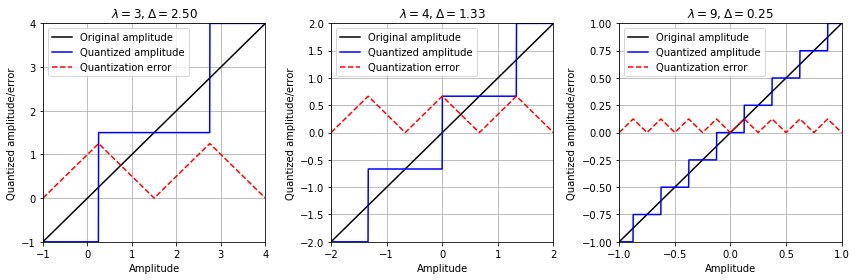

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import librosa
from IPython.display import Audio

import sys
sys.path.append(os.path.join('..','LibUNTREF'))
import C1S3_AudioRep

%matplotlib inline

def quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=5):
    """Uniform quantization approach
    Args:
        x: Original signal
        quant_min: Minimum quantization level
        quant_max: Maximum quantization level
        quant_level: Number of quantization levels
    Returns:
        x_quant: Quantized signal
    """    
    x_normalize  = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize>quant_level-1] = quant_level-1
    x_normalize[x_normalize<0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant

def plot_graph_quant_function(ax, quant_min=-1, quant_max=1, quant_level=256, mu='255', quant='uniform'):
    """Helper function for plotting a graph of quantization function and quantization error
    """      
    x = np.linspace(quant_min, quant_max, 1000)
    if quant=='uniform':
        x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, quant_level=quant_level)
        quant_stepsize = (quant_max - quant_min) / (quant_level-1)
        title = r'$\lambda = %d, \Delta=%0.2f$'%(quant_level, quant_stepsize)
    if quant=='nonuniform':
        x_quant = quantize_nonuniform_mu(x, mu=mu, quant_level=quant_level)
        title = r'$\lambda = %d, \mu=%0.1f$'%(quant_level, mu)
    error = np.abs(x_quant - x)
    ax.plot(x, x, color='k', label='Original amplitude')
    ax.plot(x, x_quant, color='b', label='Quantized amplitude')
    ax.plot(x, error, 'r--', label='Quantization error') 
    ax.set_title(title)
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Quantized amplitude/error')
    ax.set_xlim([quant_min, quant_max])
    ax.set_ylim([quant_min, quant_max])
    ax.grid('on')
    ax.legend()
    
plt.figure(figsize=(12,4))
ax = plt.subplot(1, 3, 1)
plot_graph_quant_function(ax, quant_min=-1, quant_max=4, quant_level=3)
ax = plt.subplot(1, 3, 2)
plot_graph_quant_function(ax, quant_min=-2, quant_max=2, quant_level=4)
ax = plt.subplot(1, 3, 3)
plot_graph_quant_function(ax, quant_min=-1, quant_max=1, quant_level=9)
plt.tight_layout()
plt.show()

## Example for Uniform Quantization: Sinusoid

In the following code cell, we illustrate the result of uniform quantization for different parameter settings using a sinusoid as an example signal.

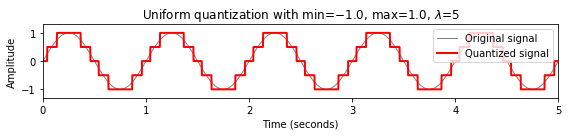

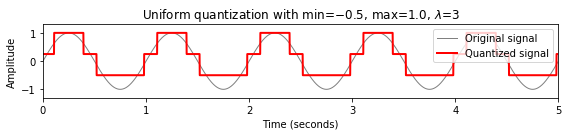

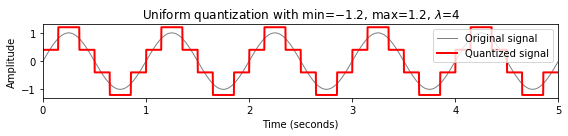

In [3]:
def plot_signal_quant(x, t, x_quant, figsize=(8, 2), xlim=None, ylim=None, title=''):
    """Helper function for plotting a signal and its quantized version
    """    
    plt.figure(figsize=(8, 2))
    plt.plot(t, x, color='gray', linewidth=1.0, linestyle='-', label='Original signal')
    plt.plot(t, x_quant, color='red', linewidth=2.0, linestyle='-', label='Quantized signal')
    if xlim is None:
        plt.xlim([0, t[-1]])
    else:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

dur = 5
x, t = C1S3_AudioRep.generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1, phase=0.0)

quant_min = -1
quant_max = 1
quant_level = 5
x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, 
                          quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
                  title=r'Uniform quantization with min=$%0.1f$, max=$%0.1f$, $\lambda$=$%d$'%(quant_min, quant_max, quant_level));

quant_min = -0.5
quant_max = 1
quant_level = 3
x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, 
                          quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
                  title=r'Uniform quantization with min=$%0.1f$, max=$%0.1f$, $\lambda$=$%d$'%(quant_min, quant_max, quant_level));

quant_min = -1.2
quant_max = 1.2
quant_level = 4
x_quant = quantize_uniform(x, quant_min=quant_min, quant_max=quant_max, 
                          quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
                  title=r'Uniform quantization with min=$%0.1f$, max=$%0.1f$, $\lambda$=$%d$'%(quant_min, quant_max, quant_level));


## Quantization Noise

The quantization of a signal is a lossy operation. The distortions introduced by this process are referred to as **quantization noise**. In the following code cell, we give an impression of these distortions by quantizing a piano recording of a C-major scale using a different number of bits to encode sample values. Note that one can encode $2^b$ different quantization levels using $b\in\mathbb{N}$ bits.

In [4]:
def display_signal_quant(x, Fs, number_of_bits):
    quant_level = 2 ** number_of_bits
    x_quant = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)    
    print('Signal after uniform quantization (%d bits) :'%number_of_bits, flush=True)
    display( Audio(x_quant, rate=Fs) )
    return x_quant

file_name = os.path.join('..', 'data', 'C2', 'FMP_C2_Sampling_C-major-scale.wav')
x, Fs = librosa.load(file_name, sr=11025)

print('Original audio signal (16 bits):', flush=True)
display( Audio(x, rate=Fs) )

x_quant = display_signal_quant(x=x, Fs=Fs, number_of_bits=8)
x_quant = display_signal_quant(x=x, Fs=Fs, number_of_bits=4)
x_quant = display_signal_quant(x=x, Fs=Fs, number_of_bits=2)

Original audio signal (16 bits):


Signal after uniform quantization (8 bits) :


Signal after uniform quantization (4 bits) :


Signal after uniform quantization (2 bits) :


## Nonuniform Quantization

In **uniform** quantization, the quantization levels are spaced in an **equidistant** fashion. If this is not the case, one also speaks of **nonuniform** quantization. For example, for audio signals, one often chooses quantization levels that are spaced in a **logarithmic** fashion. This is motivated by the fact that the human perception of sound intensity is logarithmic in nature. Therefore, from a perceptual viewpoint, it may be  beneficial to utilize more bits for encoding lower amplitude values (where a human is more sensitive to variations in sound intensity) than for encoding higher amplitude values. One approach to logarithmic quantization involves the [**$\mu$-law encoding**](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm), which is defined as follows:

\begin{equation}
F_\mu(v) = \mathrm{sgn}(v) \frac{\ln(1+ \mu |v|)}{\ln(1+\mu)}
\end{equation}

for values $v\in[-1,1]$, where $\mathrm{sgn}$ denotes the signum function. The parameter $\mu\in\mathbb{R}_{>0}$ is an integer that determines the degree of compression applied. In practice, one often uses $\mu=255$ for deriving a nonuniform $8$-bit quantization scheme. The encoding $F_\mu$ is a strictly increasing monotonous function, which maps the interval $[-1,1]$ to itself where lower values are expanded and higher values are compressed. Its inverse, the [**$\mu$-law decoding**](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm), is given by:

\begin{equation}
F_\mu^{-1}(v) = \mathrm{sgn}(v) \frac{(1 + \mu)^{|v|}- 1}{\mu}
\end{equation}

for values $v\in[-1,1]$. In the following code cell, we implement the function $F_\mu$ and its inverse $F_\mu^{-1}$ and illustrate their behavior for different parameter $\mu$.

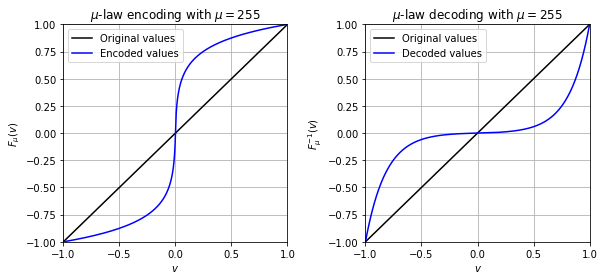

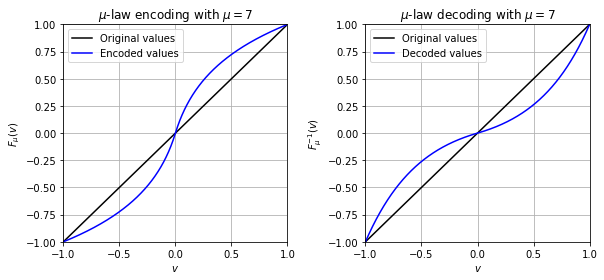

In [5]:
def encoding_mu_law(v, mu=255.0):
    """mu-law encoding
    Args:
        v: Value between -1 and 1
        mu: Encoding parameter
    Returns:
        v_encode: Encoded value
    """    
    v_encode = np.sign(v) * (np.log(1.0 + mu * np.abs(v)) / np.log(1.0 + mu))
    return v_encode

def decoding_mu_law(v, mu=255.0):
    """mu-law decoding
    Args:
        v: Value between -1 and 1
        mu: Dencoding parameter
    Returns:
        v_decode: Decoded value
    """    
    v_decode = np.sign(v) * (1.0 / mu) * ((1.0 + mu)**np.abs(v) - 1.0)
    return v_decode

def plot_mu_law(mu=255.0, figsize=(8.5,4)):
    """Helper function for plotting a signal and its quantized version
    """
    values = np.linspace(-1, 1, 1000)
    values_encoded = encoding_mu_law(values, mu=mu)
    values_decoded = decoding_mu_law(values, mu=mu)

    plt.figure(figsize=figsize)
    ax = plt.subplot(1, 2, 1)
    ax.plot(values, values, color='k', label='Original values')
    ax.plot(values, values_encoded, color='b', label='Encoded values')
    ax.set_title('$\mu$-law encoding with $\mu=%.0f$'%mu)
    ax.set_xlabel('$v$')
    ax.set_ylabel('$F_\mu(v)$')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid('on')
    ax.legend()

    ax = plt.subplot(1, 2, 2)
    ax.plot(values, values, color='k', label='Original values')
    ax.plot(values, values_decoded, color='b', label='Decoded values')
    ax.set_title('$\mu$-law decoding with $\mu=%.0f$'%mu)
    ax.set_xlabel('$v$')
    ax.set_ylabel('$F_\mu^{-1}(v)$')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.grid('on')
    ax.legend()

    plt.tight_layout()
    plt.show()
    
plot_mu_law(mu=255.0)
plot_mu_law(mu=7.0)

## Implementation of Nonuniform Quantization

In our **nonuniform quantization approach**, we first encode the given signal using $F_\mu$, then apply uniform quantization, and finally decode the resulting quantized signal using $F_\mu^{-1}$. This procedure is implemented in the following code cell, where we restrict to the case that the signal's samples are in the range $[-1,1]$. The subsequent plot illustrates the difference between uniform and nonuniform quantization continuing our sinusoid example from above.

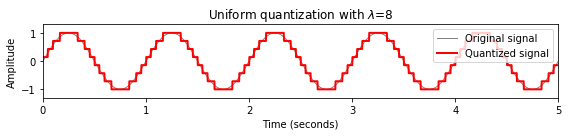

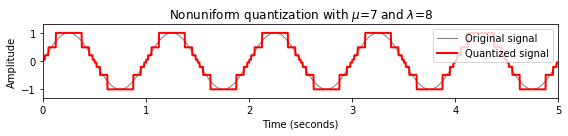

In [6]:
def quantize_nonuniform_mu(x, mu=255, quant_level=256):
    """Nonuniform quantization approach using mu-encoding
    Args:
        x: Original signal
        mu: Encoding parameter
        quant_level: Number of quantization levels
    Returns:
        x_quant: Quantized signal
    """    
    x_en = encoding_mu_law(x, mu=mu)
    x_en_quant = quantize_uniform(x_en, quant_min=-1, quant_max=1, quant_level=quant_level)
    x_quant = decoding_mu_law(x_en_quant, mu=mu)
    return x_quant

dur = 5
x, t = C1S3_AudioRep.generate_sinusoid(dur=dur, Fs=1000, amp=1, freq=1, phase=0.0)

quant_level = 8
x_quant = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
title=r'Uniform quantization with $\lambda$=$%d$'%(quant_level));

mu = 7
x_quant = quantize_nonuniform_mu(x, mu=mu, quant_level=quant_level)
plot_signal_quant(x, t, x_quant, xlim=[0, dur], ylim=[-1.3,1.3], 
title=r'Nonuniform quantization with $\mu$=$%d$ and $\lambda$=$%d$'%(mu, quant_level));

The above approach results in a nonuniform quantization function, which depends on the two parameters $\mu$ (encoding parameter) and $\lambda$ (number of quantization levels in the interval $[-1,1]$). In the following code cell, we show the graph of the quantization function as well as the quantization error for different parameter settings. Note that the quantization error is much lower for values $v$ with $|v|\approx 0$, than for values $v$ with $|v|\approx 1$.

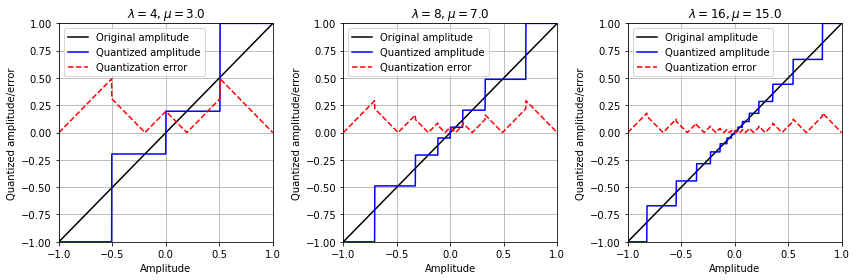

In [7]:
plt.figure(figsize=(12,4))
ax = plt.subplot(1, 3, 1)
plot_graph_quant_function(ax, mu=3, quant_level=4, quant='nonuniform')
ax = plt.subplot(1, 3, 2)
plot_graph_quant_function(ax, mu=7, quant_level=8, quant='nonuniform')
ax = plt.subplot(1, 3, 3)
plot_graph_quant_function(ax, mu=15, quant_level=16, quant='nonuniform')
plt.tight_layout()
plt.show()

## Quantization Noise for Uniform and Nonuniform Quantization

Finally, using the piano recording of a C-major scale from above, we compare the **quantization noise** resulting from uniform and nonuniform quantization. Again, we consider different numbers of bits to encode sample values. In particular, one perceives a lower noise level when using $8$-bit nonuniform quantization than when using $8$-bit uniform quantization. 

In [9]:
import B_Audio

def compare_quant_signal(x, Fs, number_of_bits):
    quant_level = 2 ** number_of_bits
    mu = quant_level-1
    x_qu = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)    
    x_qn = quantize_nonuniform_mu(x, mu=mu, quant_level=quant_level)
    B_Audio.audio_player_list([x, x_qu, x_qn], [Fs, Fs, Fs], width=160, 
                columns=['Original (16 bits)', 'Uniform (%d bits)'%number_of_bits, 'Nonuniform (%d bits)'%number_of_bits])

file_name = os.path.join('..', 'data', 'C2', 'FMP_C2_Sampling_C-major-scale.wav')
x, Fs = librosa.load(file_name, sr=11025)

compare_quant_signal(x, Fs, number_of_bits=8)
compare_quant_signal(x, Fs, number_of_bits=4)
compare_quant_signal(x, Fs, number_of_bits=2)

Original (16 bits),Uniform (8 bits),Nonuniform (8 bits)


Original (16 bits),Uniform (4 bits),Nonuniform (4 bits)


Original (16 bits),Uniform (2 bits),Nonuniform (2 bits)


In [10]:
from IPython.core.display import HTML
css_file = '.././styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())